<a href="https://colab.research.google.com/github/sindhu213/Research-Papers/blob/master/src/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchdata

In [ ]:
!python -m spacy download de_core_news_sm 
!python -m spacy download en_core_web_sm

In [41]:
import re
import spacy
import torch
import random
import math
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchtext.datasets import Multi30k
from torchtext.vocab import build_vocab_from_iterator

# Preparing Data

In [4]:
## dataset: Tuple[str: src_lang(de), str: tgt_lang(en)]
train,valid,test = Multi30k()

In [5]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [6]:
def tokenize_en(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_de(text):
  return [tok.text for tok in spacy_de.tokenizer(text)]

In [7]:
def yield_tokens(iterator,lang):
  for src,tgt in iterator:
    if lang is 'de':  yield tokenize_de(src)
    else:  yield tokenize_en(tgt)

In [8]:
src_vocab = build_vocab_from_iterator(yield_tokens(train,'de'),min_freq=2,specials=["<unk>","<pad>","<bos>","<eos>"])
src_vocab.set_default_index(0)

tgt_vocab = build_vocab_from_iterator(yield_tokens(train,'en'),min_freq=2,specials=["<unk>","<pad>","<bos>","<eos>"])
tgt_vocab.set_default_index(0)

In [9]:
print("SRC_VOCAB_SIZE: ",len(src_vocab))
print("TGT_VOCAB_SIZE: ",len(tgt_vocab))

SRC_VOCAB_SIZE:  8014
TGT_VOCAB_SIZE:  6191


In [10]:
src_pipeline = lambda x: src_vocab(["<bos>",*tokenize_de(x),"<eos>"])
tgt_pipeline = lambda x: tgt_vocab(["<bos>",*tokenize_en(x),"<eos>"])

In [11]:
def collate_batch(data_iter):
  src,tgt = [],[]
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  for src,tgt in data_iter:
    src_encoded = src_pipeline(src)
    src.append(torch.tensor(src_encoded,dtype=torch.int64,device=device))
    tgt_encoded = tgt_pipeline(tgt)
    tgt.append(torch.tensor(tgt_encoded,dtype=torch.int64,device=device))

  src = pad_sequence(src,batch_first=True,padding_value=1)
  tgt = pad_sequence(tgt,batch_first=True,padding_value=1)

  return src.to(device),tgt.to(device)

In [12]:
BATCH_SIZE = 64

TRAIN_DL = DataLoader(train,BATCH_SIZE,shuffle=True,collate_fn=collate_batch,drop_last=True)
VALID_DL = DataLoader(valid,BATCH_SIZE,shuffle=False,collate_fn=collate_batch,drop_last=True)
TEST_DL = DataLoader(test,BATCH_SIZE,shuffle=False,collate_fn=collate_batch,drop_last=True)

# Model Architecture

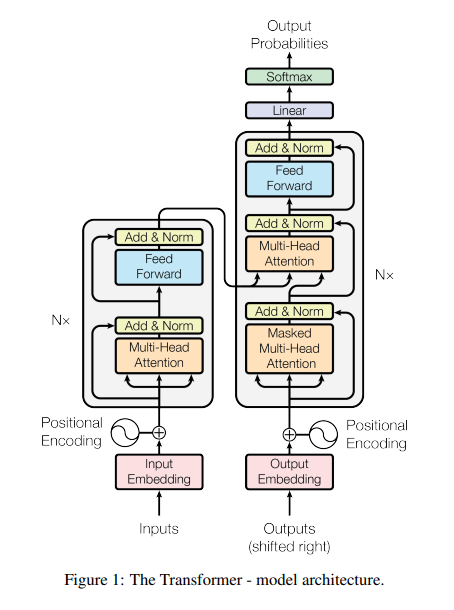

## Modules

### Positional Encoding

In [54]:
class PositionalEncoding(nn.Module):
  
  def __init__(self):
    super().__init__()

  def forward(self,x):
    """
    INPUT: 
      x : [batch_size,seq_length,d_model]
      
    OUTPUT: 
      pos_encoding: [batch_size,seq_length,d_model]
    """
    batch_size, seq_length, d_model = x.shape
    
    pos_encoding = torch.zeros(seq_length,d_model)

    # div_term: [seq_length,d_model//2]
    div_term = (10000**(torch.arange(0,d_model,2)/d_model))\
                .unsqueeze(0).repeat(seq_length,1)
    
    # seq_range: [seq_length,1]
    seq_range = torch.arange(seq_length).unsqueeze(1)

    pos_encoding[:,::2] = torch.sin(seq_range/div_term)
    pos_encoding[:,1::2] = torch.cos(seq_range/div_term)

    return pos_encoding.repeat(batch_size,1,1)

### Attention

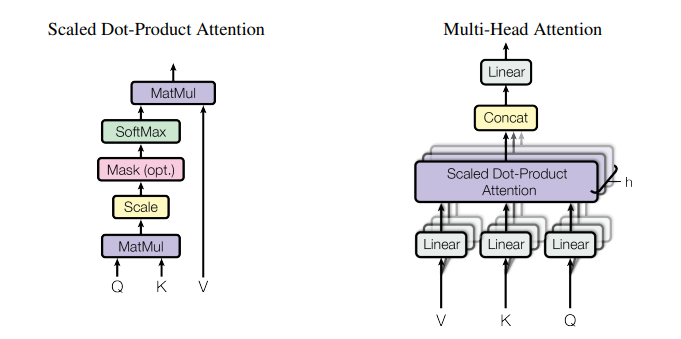

In [55]:
class MultiHeadAttention(nn.Module):

  def __init__(self,n_heads,d_model):
    super().__init__()

    assert d_model % n_heads == 0
    self.n_heads = n_heads
    self.hid_dim = d_model/n_heads
    self.fc_k = nn.Linear(d_model,d_model)
    self.fc_q = nn.Linear(d_model,d_model)
    self.fc_v = nn.Linear(d_model,d_model)
    self.fc_o   = nn.Linear(d_model,d_model)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self,query,key,value,is_masked=False): 
    """
    INPUT:
       query: [batch_size,query_len,d_model]
       key: [batch_size,key_len,d_model]
       value: [batch_size,value_len,d_model]

    OUTPUT:
      out: [batch_size,query_len,d_model]
    """

    assert query.shape[1] == key.shape[1] == value.shape[1]

    batch_size,key_len,d_model = key.shape
    scale = torch.sqrt(torch.tensor([d_model]))

    # key: [batch_size,key_len,d_model]
    # query: [batch_size,query_len,d_model]
    # value: [batch_size,value_len,d_model]
    key = self.fc_k(key)
    query = self.fc_q(query)
    value = self.fc_v(value)

    # key:[batch_size,n_heads,key_len,hid_dim]
    # query: [batch_size,n_heads,query_len,hid_dim]
    # value: [batch_size,n_heads,value_len,hid_dim]
    key = key.view(batch_size,self.n_heads,-1,self.hid_dim)
    query = query.view(batch_size,self.n_heads,-1,self.hid_dim)
    value = value.view(batch_size,self.n_heads,-1,self.hid_dim)

    # out: [batch_size,n_heads,query_len,key_len]
    out = torch.matmul(query,key.permute(0,1,3,2))/scale

    if is_masked is True:
      temp = torch.tril(out)
      out = temp.masked_fill(temp==0,-1e10)
      
    # out: [batch_size,n_heads,query_len,key_len]
    out = self.softmax(out)

    # out: [batch_size,n_heads,query_len,hid_dim]
    out = torch.matmul(out,value)
    
    # out: [batch_size,query_len,d_model]
    out = out.permute(0,2,1,3).reshape(batch_size,-1,self.d_model)

    # out: [batch_size,query_len,d_model]
    out = self.fc_o(out)

    return out

### Position-wise Feed-Forward Networks

In [56]:
class PositionwiseFeedForwardNetwork(nn.Module):

  def __init__(self,d_model,ff_hid_dim):
    super().__init__()
    self.xf = nn.Linear(d_model,ff_hid_dim)
    self.ff = nn.Linear(ff_hid_dim,d_model)
    self.relu = nn.ReLU(inplace=False)

  def forward(self,x):
    """
    INPUT:
      x: [batch_size,src_len,d_model]

    OUTPUT: 
      out: [batch_size,src_len,d_model]
    """
    # out: [batch_size,src_len,ff_hid_dim]
    out = self.relu(self.xf(x))

    # out: [batch_size,src_len,d_model]
    out = self.ff(out)

    return out

### Encoder layer

In [57]:
class EncoderLayer(nn.Module):

  def __init__(self,d_model,n_heads,ff_hid_dim,dropout):
    super().__init__()
    self.attention = MultiHeadAttention(n_heads,d_model)
    self.ia_layernorm = nn.LayerNorm(d_model)
    self.ff =  PositionwiseFeedForwardNetwork(d_model,ff_hid_dim)
    self.af_layernorm = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self,x):
    """
    INPUT:
      x: [batch_size,src_len,d_model]

    OUTPUT:
      out: [batch_size,src_len,d_model]
    """
    # attn_out: [batch_size,query_len,d_model]
    attn_out = self.attention(x,x,x)

    # out: [batch_size,src_len,d_model]
    out = self.ia_layernorm(self.dropout(attn_out) + x)

    # ff_out: [batch_size,src_len,d_model]
    ff_out = self.ff(out)

    # out: [batch_size,src_len,d_model]
    out = self.af_layernorm(self.dropout(ff_out) + attn_out)

    return out

### Decoder Layer

In [58]:
class DecoderLayer(nn.Module):

  def __init__(self,n_heads,d_model,ff_hid_dim,dropout):
    super().__init__()
    self.i_ma_layernorm = nn.LayerNorm(d_model)
    self.ma_a_layernorm = nn.LayerNorm(d_model)
    self.a_ff_layernorm = nn.LayerNorm(d_model)
    self.masked_attention = MultiHeadAttention(n_heads,d_model)
    self.attention = MultiHeadAttention(n_heads,d_model)
    self.ff = PositionwiseFeedForwardNetwork(d_model,ff_hid_dim)
    self.dropout = dropout

  def forward(self,x,enc_out):
    """
    INPUT:
      x: [batch_size,tgt_len,d_model]
      enc_out: [batch_size,query_len,d_model]

    OUTPUT:
      out: [batch_size,tgt_len,d_model]
    """
    # masked_attn_out: [batch_size,tgt_len,d_model]
    masked_attn_out = self.masked_attention(x,x,x,is_masked=True)

    # out: [batch_size,tgt_len,d_model]
    out = self.i_ma_layernorm(self.dropout(masked_attn_out)+x)

    # out: [batch_size,tgt_len,d_model]
    attn_out = self.attention(out,enc_out,enc_out,is_masked=True)

    # out: [batch_size,tgt_len,d_model]
    out = self.ma_a_layernorm(self.dropout(attn_out)+out)

    # out: [batch_size,tgt_len,d_model]
    ff_out = self.ff(out)

    # out: [batch_size,tgt_len,d_model]
    out = self.a_ff_layernorm(self.dropout(ff_out)+out)

    return out

## Encoder

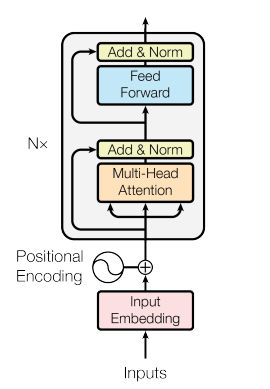

In [59]:
class Encoder(nn.Module):

  def __init__(self,n_layers,src_vocab_size,d_model,n_heads,ff_hid_dim,dropout):
    super().__init__()
    self.input_embedding = nn.Embedding(src_vocab_size,d_model,padding_idx=1)
    self.pos_encoding = PositionalEncoding()
    self.stacked_encoder_layers = nn.ModuleList([EncoderLayer(d_model,n_heads,ff_hid_dim,dropout)\
                                  for _ in range(n_layers)])
    self.dropout = nn.Dropout(dropout)

  def forward(self,x):
    """
    INPUT:
      x: [batch_size,src_len]
    
    OUTPUT:
      out: [batch_size,src_len,d_model]
    """
    # out: [batch_size,src_len,d_model]
    out = self.input_embedding(x)

    # out: [batch_size,src_len,d_model]
    out = self.dropout(self.pos_encoding(out) + out)

    for module in self.stacked_encoder_layers:
      out = module(out)

    return out

## Decoder

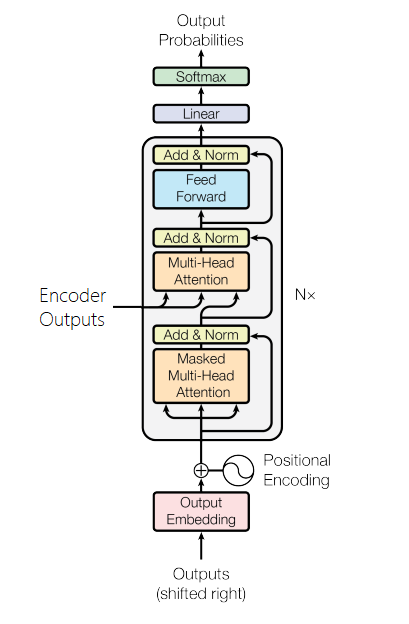

In [60]:
class Decoder(nn.Module):
  
  def __init__(self,n_layers,tgt_vocab_size,d_model,n_heads,ff_hid_dim,dropout):
    super().__init__()
    self.output_embedding = nn.Embedding(tgt_vocab_size,d_model)
    self.pos_encoding = PositionalEncoding()
    self.stacked_decoder_layers = nn.ModuleList([DecoderLayer(n_heads,d_model,ff_hid_dim,dropout)\
                                 for _ in range(n_layers)])
    self.linear = nn.Linear(d_model,tgt_vocab_size)
    self.softmax = nn.Softmax(dim=-1)   
    self.dropout = nn.Dropout(dropout)

  def forward(self,tgt,enc_out):
    """
    INPUT:
      tgt: [batch_size,tgt_len]
      enc_out: [batch_size,query_len,d_model]

    OUTPUT: 
      out: [batch_size,tgt_len,tgt_vocab_size]
    """
    # out: [batch_size,tgt_len,d_model]
    out = self.output_embedding(tgt)

    # out: [batch_size,tgt_len,d_model]
    out = self.dropout(self.pos_encoding(out) + out)

    # out: [batch_size,tgt_len,d_model]
    for module in self.stacked_decoder_layers:
      out = module(out,enc_out)

    # out: [batch_size,tgt_len,tgt_vocab_size]
    out = self.linear(out)

    return self.softmax(out)

## Transformer

In [61]:
class Transformer(nn.Module):

  def __init__(self,encoder,decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self,src,tgt):
    """
    INPUT:
      src: [batch_size,src_len]
      tgt: [batch_size,tgt_len]

    OUTPUT:
      dec_out: [batch_size,tgt_len,tgt_vocab_size]
    """
    # enc_out: [batch_size,query_len,d_model]
    enc_out = self.encoder(src)

    # dec_out: [batch_size,tgt_len,tgt_vocab_size]
    dec_out = self.decoder(tgt,enc_out)

    return dec_out

# Model Initialization

In [62]:
N_LAYERS = 3  
SRC_VOCAB_SIZE = len(src_vocab)
TGT_VOCAB_SIZE = len(tgt_vocab)
D_MODEL = 512
N_HEADS = 8
FF_HID_DIM = 2048
DROPOUT_ENC = 0.1
DROPOUT_DEC = 0.1
WARMUP_STEPS = 2000
NOISE = 1e-06

In [63]:
ENCODER = Encoder(N_LAYERS,SRC_VOCAB_SIZE,D_MODEL,N_HEADS,FF_HID_DIM,DROPOUT_ENC)
DECODER = Decoder(N_LAYERS,TGT_VOCAB_SIZE,D_MODEL,N_HEADS,FF_HID_DIM,DROPOUT_DEC)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Transformer(ENCODER,DECODER).to(device)

In [ ]:
def init_params(model_):
  for name,param in model_.named_parameters():
    if 'weight' in name and param.ndim>1:
      nn.init.xavier_uniform_(param)

model.apply(init_params)

In [65]:
def count_parameters(model):
  return sum(param.numel() for param in model.parameters() if param.requires_grad)

print("Number of trainable params in Encoder: {:,}".format(count_parameters(ENCODER)))
print("Number of trainable params in Decoder: {:,}".format(count_parameters(DECODER)))
print("Number of trainable params in seq2seq: {:,}".format(count_parameters(model)))

Number of trainable params in Encoder: 13,560,320
Number of trainable params in Decoder: 18,957,871
Number of trainable params in seq2seq: 32,518,191


In [66]:
lr_lambda = lambda epoch: math.pow(D_MODEL,-1/2)*min(math.pow(epoch+NOISE,-1/2),epoch*math.pow(WARMUP_STEPS,-3/2))

loss_fn = nn.CrossEntropyLoss(ignore_index=1,label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(),betas=(0.9, 0.999), eps=1e-09,lr=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,lr_lambda)

# Model Training and Evaluation

In [73]:
def train(data_iter):
  model.train()
  epoch_loss = 0.0
  len_data_iter = 29001//BATCH_SIZE

  #data: [batch_size,src_len]
  #label: [batch_size,tgt_len]
  for data,label in data_iter:
    optimizer.zero_grad()

    # pred: [batch_size,tgt_len,tgt_vocab_size]
    pred = model(data,label[:,:-1])

    # pred: [batch_size*tgt_len,tgt_vocab_size]
    pred = pred.reshape(-1,TGT_VOCAB_SIZE)

    #label: [batch_size*tgt_len]
    label = label.reshape(-1)

    #loss: [batch_size*tgt_len]
    loss = loss_fn(pred,label)

    epoch_loss += loss.item()
    loss.backward()
    optimizer.step()

  return epoch_loss/len_data_iter

In [74]:
def evaluate(data_iter):
  model.eval()
  epoch_loss = 0.0
  len_data_iter = 1014//BATCH_SIZE

  #data: [batch_size,src_len]
  #label: [batch_size,tgt_len]
  with torch.no_grad():
    for data,label in data_iter:

      # pred: [batch_size,tgt_len,tgt_vocab_size]
      pred = model(data,label[:,:-1])

      # pred: [batch_size*tgt_len,tgt_vocab_size]
      pred = pred.reshape(-1,TGT_VOCAB_SIZE)

      #label: [batch_size*tgt_len]
      label = label.reshape(-1)

      #loss: [batch_size*tgt_len]
      loss = loss_fn(pred,label)

      epoch_loss += loss.item()

  return epoch_loss/len_data_iter

In [ ]:
NUM_EPOCHS = 50
for epoch in range(NUM_EPOCHS):
  train_loss = train(TRAIN_DL)
  eval_loss = evaluate(VALID_DL)
  print("EPOCH: ",epoch)
  print("------- TRAINING_LOSS: {: .4f} | EVAL_LOSS: {: .4f} | LR: {: .4f}".format(train_loss,eval_loss,optimizer.param_groups[0]['lr']))
  scheduler.step()